In [1]:
import tensorflow as tf
from keras.optimizer_v1 import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [3]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [4]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [5]:
BATCH_SIZE = 32

EPOCHS = 100

In [6]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = 'C:\\Users\\Ali\Documents\\minipigs_images\\Split_Data\\train'

# path to VALIDATE dataset of the OCT images
VALID_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\val'

# path to TESTING dataset of the OCT images
TEST_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_images\\Split_Data\\test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [7]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-10]:
    layer.trainable = False

In [8]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [9]:
# more layers could be added to the model
x = Flatten()(orig_model.output)


prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [13]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 210 images belonging to 5 classes.


In [14]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [15]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 60 images belonging to 5 classes.


In [16]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 35 images belonging to 5 classes.


In [17]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

Epoch 1/100
7/7 [==============================] - 41s 5s/step - loss: 2.4818 - accuracy: 0.2286 - val_loss: 2.8128 - val_accuracy: 0.2500
Epoch 2/100
7/7 [==============================] - 27s 4s/step - loss: 1.8869 - accuracy: 0.3286 - val_loss: 2.0262 - val_accuracy: 0.3333
Epoch 3/100
7/7 [==============================] - 27s 4s/step - loss: 1.7829 - accuracy: 0.3571 - val_loss: 2.2858 - val_accuracy: 0.3167
Epoch 4/100
7/7 [==============================] - 26s 4s/step - loss: 1.5042 - accuracy: 0.4381 - val_loss: 2.0290 - val_accuracy: 0.3167
Epoch 5/100
7/7 [==============================] - 26s 4s/step - loss: 1.3642 - accuracy: 0.4524 - val_loss: 1.9967 - val_accuracy: 0.4000
Epoch 6/100
7/7 [==============================] - 28s 4s/step - loss: 1.4202 - accuracy: 0.5095 - val_loss: 1.9321 - val_accuracy: 0.3667
Epoch 7/100
7/7 [==============================] - 27s 4s/step - loss: 1.2965 - accuracy: 0.5190 - val_loss: 1.6273 - val_accuracy: 0.4667
Epoch 8/100
7/7 [==========

7/7 [==============================] - 86s 12s/step - loss: 0.4791 - accuracy: 0.8238 - val_loss: 0.9167 - val_accuracy: 0.7000
Epoch 60/100
7/7 [==============================] - 70s 10s/step - loss: 0.3806 - accuracy: 0.8667 - val_loss: 0.7410 - val_accuracy: 0.7833
Epoch 61/100
7/7 [==============================] - 63s 9s/step - loss: 0.4559 - accuracy: 0.8190 - val_loss: 0.5880 - val_accuracy: 0.8333
Epoch 62/100
7/7 [==============================] - 50s 7s/step - loss: 0.3775 - accuracy: 0.8810 - val_loss: 0.5894 - val_accuracy: 0.7833
Epoch 63/100
7/7 [==============================] - 51s 7s/step - loss: 0.4271 - accuracy: 0.8429 - val_loss: 0.6985 - val_accuracy: 0.7833
Epoch 64/100
7/7 [==============================] - 44s 6s/step - loss: 0.3524 - accuracy: 0.8714 - val_loss: 0.8069 - val_accuracy: 0.7333
Epoch 65/100
7/7 [==============================] - 45s 7s/step - loss: 0.4996 - accuracy: 0.8143 - val_loss: 0.7103 - val_accuracy: 0.7667
Epoch 66/100
7/7 [=============

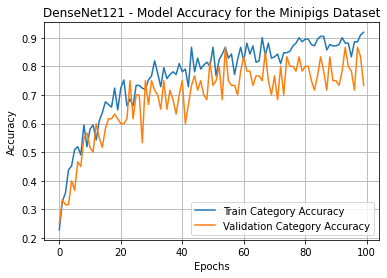

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

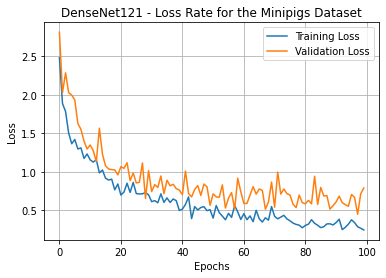

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [20]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 13s 448ms/step - loss: 0.5730 - accuracy: 0.7500

Learn Rate = 0.0001 , Epochs = 100 , Training Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\train
Validation Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\val , Test Folder = C:\Users\Ali\Documents\minipigs_images\Split_Data\test

Training: 0.905, Validation: 0.750

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [21]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 [==============================] - 11s 143ms/step - loss: 0.3136 - accuracy: 0.8857

Test loss and accuracy are: [0.3135802745819092, 0.8857142925262451]


In [22]:
model.save('model_-15layers_100epochs.h5')


Predictions:

[[1.5830963e-07 1.1394898e-05 9.3687779e-01 3.2083849e-06 6.3107476e-02]
 [8.4930554e-07 5.3381373e-06 9.9702400e-01 5.9207407e-04 2.3778628e-03]
 [6.7407805e-03 9.5165730e-04 1.2891060e-03 9.9085754e-01 1.6085290e-04]
 [1.4560852e-02 3.2537591e-03 6.2965628e-06 6.7313129e-05 9.8211181e-01]
 [7.3408109e-01 1.9147412e-01 4.5966607e-04 2.0347133e-03 7.1950398e-02]
 [2.4467869e-02 2.0139623e-03 3.1041425e-01 3.0974197e-01 3.5336196e-01]
 [1.0137061e-03 9.7406358e-01 7.4433256e-03 6.3989632e-04 1.6839508e-02]
 [1.9383302e-04 9.9752909e-01 2.5203257e-05 1.5975387e-03 6.5435772e-04]
 [5.6897599e-04 9.8349762e-01 7.5912056e-04 6.2456746e-03 8.9286081e-03]
 [1.0297562e-03 1.4689890e-03 7.9521582e-02 2.7825547e-02 8.9015412e-01]
 [6.7748660e-01 2.9780048e-01 2.8633981e-06 1.3363721e-02 1.1346365e-02]
 [9.9839419e-01 6.2078284e-04 4.2828208e-07 1.0935410e-04 8.7513105e-04]
 [8.7989593e-04 2.3301762e-02 9.2764312e-06 2.9803208e-05 9.7577924e-01]
 [2.1410702e-02 1.5883155e-02 3.1989

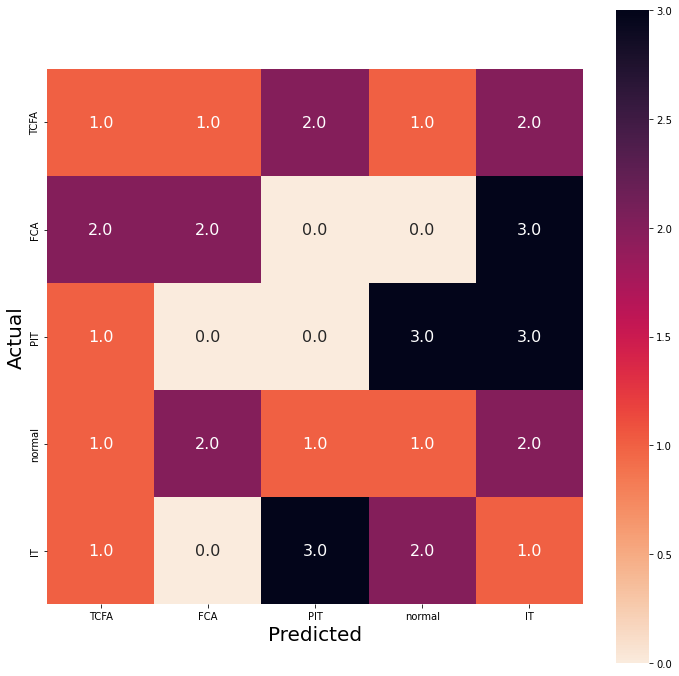

In [24]:
cnn_predictions = model.predict(test_set)
print('\nPredictions:\n')
print(cnn_predictions)

cnn_predictions_max = cnn_predictions.argmax(axis=1)
print('\nPredictions argmax(axis=1):\n')
print(cnn_predictions_max)

print(test_set.labels)

print('\nTesting execution ended.\n')

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

label = ['TCFA', 'FCA', 'PIT', 'normal', 'IT']
#Ypred = np.argmax(cnn_predictions, axis=1)
#Ytrue = np.argmax(test_set.labels, axis=0)

cm = confusion_matrix(test_set.labels, cnn_predictions_max)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()